# Spring 2023-CS 550 Massive Data Mining (Final Project) <br>
# Team-30<br>
**4.(d) Optional Task**: 
**Trustworthiness of Recommendation Systems** <br><br>
**Primary Topic**: Privacy Protection For Recommender Systems<br>
**Sub Topic:** Differential Privacy In Recommender Systems     
  

Experimental Dataset: Movie Lens (Small) <br>
Description Link: https://files.grouplens.org/datasets/movielens/ml-latest-small-README.html

Step 1: Download the MovieLens-small dataset (Google Drive Link: https://drive.google.com/drive/folders/1RgGBTN8EKtC7YwpM092ujj4IIdl92r1e?usp=share_link)

In [227]:
#Download only the user ratings data
!gdown '1yVast4gak_2Guibr4Um6LnPPQNoGwJLJ' -O ratings.csv

Downloading...
From: https://drive.google.com/uc?id=1yVast4gak_2Guibr4Um6LnPPQNoGwJLJ
To: /content/ratings.csv
100% 2.48M/2.48M [00:00<00:00, 196MB/s]


Install pre-requisite libraries

In [228]:
#Import Numpy and set seed for reproducibility
import numpy as np
np.random.seed(10)

#install pandas, tqdm, matplotlib
!pip install pandas tqdm matplotlib

#import the necessary libraries
import math
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Step 2. Visualize the user-ratings dataset present in 'ratings.csv'

In [229]:
df_ratings = pd.read_csv('ratings.csv')
df_ratings.head()
df_ratings.dtypes

userId         int64
movieId        int64
rating       float64
timestamp      int64
dtype: object

Step 3: Dataset pre-processing

Define Helper Functions 

In [232]:
def generate_user_item_maps(ratings_dataset):
    ext_int_usermap = {val: key for key, val in enumerate(ratings_dataset.iloc[:, 0].unique())}
    int_ext_usermap = {key: val for key, val in enumerate(ratings_dataset.iloc[:, 0].unique())}
    ext_int_itemmap = {val: key for key, val in enumerate(ratings_dataset.iloc[:, 1].unique())}
    int_ext_itemmap = {key: val for key, val in enumerate(ratings_dataset.iloc[:, 1].unique())}
    return ext_int_usermap, int_ext_usermap, ext_int_itemmap, int_ext_itemmap

In [233]:
def split_dataset_train_test(test_data_fraction, data):

    per_user_ratings_length = data.groupby(['userId'], as_index=True).size()
    user_threshold = per_user_ratings_length.apply(lambda x: math.floor(x * (1 - test_data_fraction)))
    
    data['r'] = data.groupby(['userId'])['timestamp'].rank(method='first', ascending=True)
    data["t"] = data.apply(
        lambda x: x["r"] > user_threshold.loc[x["userId"]], axis=1)
    
    train_dataset = data[data["t"] == False].drop(columns=["r", "t"]).reset_index(drop=True)
    test_dataset = data[data["t"] == True].drop(columns=["r", "t"]).reset_index(drop=True)

    return train_dataset, test_dataset


User Ratings Test Train Split

In [234]:
test_data_fraction=0.2
train_data_fraction=1-test_data_fraction

In [235]:
train_dataset, test_dataset = split_dataset_train_test(test_data_fraction,df_ratings)

In [236]:
train_dataset.drop('timestamp', inplace=True, axis=1)
test_dataset.drop('timestamp', inplace=True, axis=1)

In [237]:
maps_dict = generate_user_item_maps(train_dataset)

Step 4: Create The Matrix factorization Model Class

In [238]:
class MatrixFactorization:
    def __init__(self, dataset, maps_dict, n_factors, relevance=3.5, i_avg=None, u_avg=None):

        self.ext2int_user_map, self.int2ext_user_map, self.ext2int_item_map, self.int2ext_item_map = maps_dict
        self.dataset = self.format_dataset(dataset)
        self.rated_items = {
            self.ext2int_user_map[u]: dataset[(dataset.iloc[:, 0] == u) & (dataset.iloc[:, 2] >= relevance)].iloc[:,
                                      1].map(self.ext2int_item_map).astype(int).to_list() for u in
            self.ext2int_user_map}
        n_users = len(self.ext2int_user_map)
        n_items = len(self.ext2int_item_map)
        self.n_interactions = len(dataset)
        self.delta_ratings = dataset.iloc[:, 2].max() - dataset.iloc[:, 2].min()
        self.p = np.random.normal(size=(n_users, n_factors), scale=1./n_factors, loc=0)
        self.q = np.random.normal(size=(n_items, n_factors), scale=1./n_factors, loc=0)

        self.b_u = np.zeros(n_users)
        self.b_i = np.zeros(n_items)
        self.b = np.mean(dataset['rating'])

        self.i_avg = None
        self.u_avg = None
        if i_avg is not None and u_avg is not None:
            self.i_avg = i_avg.to_numpy()
            self.u_avg = u_avg.to_numpy()

    def format_dataset(self, df):
        dataset = {}
        dataset['userId'] = df.iloc[:, 0].map(self.ext2int_user_map).to_dict()
        dataset['itemId'] = df.iloc[:, 1].map(self.ext2int_item_map).to_dict()
        dataset['rating'] = df.iloc[:, 2].to_dict()
        return dataset

    def train(self, lr, beta, epochs):

        avg_loss_training=[]
        epochs=30

        for e in range(epochs):
            print(f"*** Epoch {e + 1}/{epochs} ***")
            
            sum_of_loss=0
            for i in tqdm(range(self.n_interactions)):

                p_u = self.p[self.dataset['userId'][i]].astype(np.float64)
                q_i = self.q[self.dataset['itemId'][i]].astype(np.float64)

                pred = self.b + self.b_u[self.dataset['userId'][i]] + self.b_i[self.dataset['itemId'][i]] + p_u.dot(q_i)
                err = self.dataset['rating'][i] - pred

                sum_of_loss+=abs(err)

                # Update biases
                self.b_u[self.dataset['userId'][i]] += lr * (err - beta * self.b_u[self.dataset['userId'][i]])
                self.b_i[self.dataset['itemId'][i]] += lr * (err - beta * self.b_i[self.dataset['itemId'][i]])

                # Update embeddings
                self.p[self.dataset['userId'][i]] = p_u + lr * (err * q_i - beta * p_u)
                self.q[self.dataset['itemId'][i]] = q_i + lr * (err * p_u - beta * q_i)
            
            avg_loss_training.append(sum_of_loss/self.n_interactions)

        plt.figure()
        plt.plot([i for i in range(epochs)], avg_loss_training)

        plt.title('Training Loss vs Epochs')
        plt.ylabel('Training Loss')
        plt.xlabel('Epochs')

    def train_laplace_dp(self, lr, beta, epochs, eps, err_max=None):

        avg_loss_training=[]
        epochs=30

        for e in range(epochs):
            print(f" Epoch {e + 1}/{epochs} started")

            sum_of_loss=0

            for i in tqdm(range(self.n_interactions)):
                p_u = self.p[self.dataset['userId'][i]].astype(np.float64)
                q_i = self.q[self.dataset['itemId'][i]].astype(np.float64)

                pred = self.b + self.b_u[self.dataset['userId'][i]] + self.b_i[self.dataset['itemId'][i]] + p_u.dot(q_i)

                # We should add Laplacian noise scaled based on the sensitivity of the error
                # Having two datasets A and B differing by the value of just one rating r_ui (namely r_ui(A) and r_ui(B)), we have that
                # max |e(A) - e(B)| = max |(r_ui(A) - p_u * q_i) - (r_ui(B) - p_u * q_i)| = max |r_ui(A) - r_ui(B)| = delta_ratings
                # For the composability theorem, we have to split the privacy budget by the number of epochs
                err = self.dataset['rating'][i] - pred + np.random.laplace(scale=(epochs * self.delta_ratings / eps))


                # Optionally we can constrain the error the limit the effect of the noise
                if err_max:
                    err = np.clip(err, -err_max, err_max)

                sum_of_loss+=abs(err)

                # Update biases
                self.b_u[self.dataset['userId'][i]] += lr * (err - beta * self.b_u[self.dataset['userId'][i]])
                self.b_i[self.dataset['itemId'][i]] += lr * (err - beta * self.b_i[self.dataset['itemId'][i]])

                self.p[self.dataset['userId'][i]] = p_u + lr * (err * q_i)
                self.q[self.dataset['itemId'][i]] = q_i + lr * (err * p_u)
              
            avg_loss_training.append(sum_of_loss/self.n_interactions)

        plt.figure()
        plt.plot([i for i in range(epochs)], avg_loss_training)

        print('TL:',avg_loss_training)
        print('Epochs:',[i for i in range(epochs)])
        plt.title('Training Loss vs Epochs')
        plt.ylabel('Training Loss')
        plt.xlabel('Epochs')


    def evaluate(self, test=None, cutoff=10, relevance=0.5):

        if self.i_avg is not None and self.u_avg is not None:
            prediction = self.b + self.b_u[:, np.newaxis] + self.b_i[np.newaxis, :] + \
                         (np.dot(self.p, self.q.T).T + self.i_avg[:, None]).T + self.u_avg[:, None]
        else:
            prediction = self.b + self.b_u[:, np.newaxis] + self.b_i[np.newaxis, :] + np.dot(self.p, self.q.T)
        precisions = []
        recalls = []

        relevant_items_test = {
            self.ext2int_user_map[u]: set(test[(test.iloc[:, 0] == u) & (test.iloc[:, 2] >= relevance)].iloc[:, 1].map(
                self.ext2int_item_map).dropna().astype(int).to_list()) for u in self.ext2int_user_map}

        for u in self.int2ext_user_map:
            prediction[u, self.rated_items[u]] = - np.inf
            unordered_top_k = np.argpartition(prediction[u], -cutoff)[-cutoff:]
            top_k = unordered_top_k[np.argsort(prediction[u][unordered_top_k])][::-1]
            n_rel_and_rec_k = sum(i in relevant_items_test[u] for i in top_k)
            precisions.append(n_rel_and_rec_k / cutoff)
            try:
                recalls.append(n_rel_and_rec_k / len(relevant_items_test[u]))
            except ZeroDivisionError:
                recalls.append(0)
        precision = sum(precisions) / len(precisions)
        recall = sum(recalls) / len(recalls)

        print(f"Precision@{cutoff}: {precision}")
        print(f"Recall@{cutoff}: {recall}")
        return  precision, recall

Define the model hyper-parameters

In [239]:
num_of_latent_factors = 100
learning_rate = 0.001
lambda_regularization = 0.1
num_of_epochs = 20

Initialize Matrix Factorization model

In [240]:
mf_model = MatrixFactorization(train_dataset, maps_dict, num_of_latent_factors, relevance=4)

Train The Matrix Factorization Model With No Input or Training Noise

*** Epoch 1/30 ***


100%|██████████| 80419/80419 [00:01<00:00, 47866.09it/s]


*** Epoch 2/30 ***


100%|██████████| 80419/80419 [00:01<00:00, 47064.50it/s]


*** Epoch 3/30 ***


100%|██████████| 80419/80419 [00:02<00:00, 33256.41it/s]


*** Epoch 4/30 ***


100%|██████████| 80419/80419 [00:02<00:00, 31690.02it/s]


*** Epoch 5/30 ***


100%|██████████| 80419/80419 [00:01<00:00, 47883.03it/s]


*** Epoch 6/30 ***


100%|██████████| 80419/80419 [00:01<00:00, 47637.87it/s]


*** Epoch 7/30 ***


100%|██████████| 80419/80419 [00:01<00:00, 47626.22it/s]


*** Epoch 8/30 ***


100%|██████████| 80419/80419 [00:01<00:00, 48015.12it/s]


*** Epoch 9/30 ***


100%|██████████| 80419/80419 [00:01<00:00, 46837.36it/s]


*** Epoch 10/30 ***


100%|██████████| 80419/80419 [00:02<00:00, 31483.52it/s]


*** Epoch 11/30 ***


100%|██████████| 80419/80419 [00:02<00:00, 34044.94it/s]


*** Epoch 12/30 ***


100%|██████████| 80419/80419 [00:01<00:00, 46824.67it/s]


*** Epoch 13/30 ***


100%|██████████| 80419/80419 [00:01<00:00, 47332.03it/s]


*** Epoch 14/30 ***


100%|██████████| 80419/80419 [00:01<00:00, 46371.34it/s]


*** Epoch 15/30 ***


100%|██████████| 80419/80419 [00:01<00:00, 48236.19it/s]


*** Epoch 16/30 ***


100%|██████████| 80419/80419 [00:01<00:00, 47038.14it/s]


*** Epoch 17/30 ***


100%|██████████| 80419/80419 [00:02<00:00, 28982.93it/s]


*** Epoch 18/30 ***


100%|██████████| 80419/80419 [00:02<00:00, 38617.18it/s]


*** Epoch 19/30 ***


100%|██████████| 80419/80419 [00:01<00:00, 47558.37it/s]


*** Epoch 20/30 ***


100%|██████████| 80419/80419 [00:01<00:00, 46538.67it/s]


*** Epoch 21/30 ***


100%|██████████| 80419/80419 [00:01<00:00, 47487.68it/s]


*** Epoch 22/30 ***


100%|██████████| 80419/80419 [00:01<00:00, 45699.24it/s]


*** Epoch 23/30 ***


100%|██████████| 80419/80419 [00:01<00:00, 46143.27it/s]


*** Epoch 24/30 ***


100%|██████████| 80419/80419 [00:03<00:00, 25075.63it/s]


*** Epoch 25/30 ***


100%|██████████| 80419/80419 [00:03<00:00, 21632.93it/s]


*** Epoch 26/30 ***


100%|██████████| 80419/80419 [00:03<00:00, 26692.00it/s]


*** Epoch 27/30 ***


100%|██████████| 80419/80419 [00:01<00:00, 46278.74it/s]


*** Epoch 28/30 ***


100%|██████████| 80419/80419 [00:01<00:00, 43967.29it/s]


*** Epoch 29/30 ***


100%|██████████| 80419/80419 [00:02<00:00, 34054.41it/s]


*** Epoch 30/30 ***


100%|██████████| 80419/80419 [00:02<00:00, 31174.28it/s]


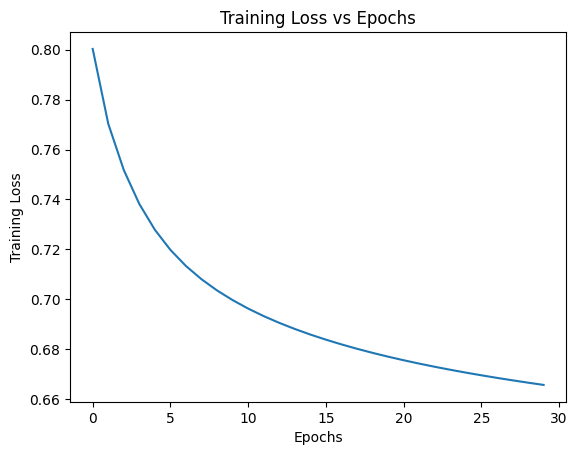

In [241]:
mf_model.train(learning_rate, lambda_regularization, num_of_epochs)

In [242]:
mf_model.evaluate(test_dataset)

Precision@10: 0.05180327868852467
Recall@10: 0.026935795874508867


(0.05180327868852467, 0.026935795874508867)

In [244]:
def privatize_global_effects(ratings, b_m, b_u, eps_global_avg, eps_item_avg, eps_user_avg, clamping):
    min_rating = ratings['rating'].min()
    max_rating = ratings['rating'].max()
    delta_r = max_rating - min_rating

    # Measure the noisy version

    global_average_item = (ratings['rating'].sum() + np.random.laplace(scale=(delta_r / eps_global_avg))) / len(ratings)

    item_sets = ratings.groupby('movieId')['rating']
    i_avg = (item_sets.sum() + b_m * global_average_item + np.random.laplace(scale=(delta_r / eps_item_avg),
                                                                             size=len(item_sets))) / (
                        item_sets.count() + b_m)
    i_avg = np.clip(i_avg, min_rating, max_rating)

    merged = ratings.join(i_avg, on=['movieId'], lsuffix='_x', rsuffix='_y')

    merged['rating'] = merged['rating_x'] - merged['rating_y']
    merged = merged.drop(columns=['rating_x', 'rating_y'], axis=1)

    global_average_user = (merged['rating'].sum() + np.random.laplace(scale=(delta_r / eps_global_avg))) / len(merged)

    user_sets = merged.groupby('userId')['rating']
    u_avg = (user_sets.sum() + b_u * global_average_user + np.random.laplace(scale=(delta_r / eps_user_avg))) / (
                user_sets.count() + b_u)
    u_avg = np.clip(u_avg, -2, 2)
    # Values come from the implementation of this approach by Friedman et al., 2016

    preprocessed_ratings = merged.join(u_avg, on=['userId'], lsuffix='_x', rsuffix='_y')

    preprocessed_ratings['rating'] = preprocessed_ratings['rating_x'] - preprocessed_ratings['rating_y']
    preprocessed_ratings = preprocessed_ratings.drop(columns=['rating_x', 'rating_y'], axis=1)
    preprocessed_ratings['rating'] = np.clip(preprocessed_ratings['rating'], -clamping, clamping)

    return preprocessed_ratings, i_avg, u_avg

In [245]:
eps = 5
eps_global_avg = 0.02 * eps
eps_item_avg = 0.14 * eps
eps_user_avg = 0.14 * eps
# Overall, we used 0.3 of our eps for the preprocessing
# The remaing 0.7 of eps is used for training

In [246]:
b_m = 5
b_u = 5
clamping = 1
preproc_train_set, i_avg, u_avg = privatize_global_effects(train_dataset, b_m, b_u, eps_global_avg, eps_item_avg,
                                                           eps_user_avg, clamping)

In [247]:
def input_perturbation(ratings, clamping, eps):
    # Range of the received ratings is [-clamping, clamping]
    # In the input perturbation approach, each rating is perturbed in a way that maintains differential privacy
    delta_r = 2 * clamping  # global sensitivity

    # differential privacy
    perturbed_ratings = ratings.copy()
    perturbed_ratings['rating'] = np.clip(ratings['rating'] + np.random.laplace(scale=(delta_r / eps), size=len(ratings)),
                                -clamping, clamping)

    return perturbed_ratings

*** Epoch 1/30 ***


100%|██████████| 80419/80419 [00:01<00:00, 44661.28it/s]


*** Epoch 2/30 ***


100%|██████████| 80419/80419 [00:01<00:00, 47298.47it/s]


*** Epoch 3/30 ***


100%|██████████| 80419/80419 [00:02<00:00, 35170.71it/s]


*** Epoch 4/30 ***


100%|██████████| 80419/80419 [00:02<00:00, 31693.21it/s]


*** Epoch 5/30 ***


100%|██████████| 80419/80419 [00:01<00:00, 47048.74it/s]


*** Epoch 6/30 ***


100%|██████████| 80419/80419 [00:01<00:00, 47551.92it/s]


*** Epoch 7/30 ***


100%|██████████| 80419/80419 [00:01<00:00, 46752.83it/s]


*** Epoch 8/30 ***


100%|██████████| 80419/80419 [00:01<00:00, 46584.59it/s]


*** Epoch 9/30 ***


100%|██████████| 80419/80419 [00:01<00:00, 48969.40it/s]


*** Epoch 10/30 ***


100%|██████████| 80419/80419 [00:02<00:00, 32578.67it/s]


*** Epoch 11/30 ***


100%|██████████| 80419/80419 [00:02<00:00, 33283.72it/s]


*** Epoch 12/30 ***


100%|██████████| 80419/80419 [00:01<00:00, 47010.45it/s]


*** Epoch 13/30 ***


100%|██████████| 80419/80419 [00:01<00:00, 47025.79it/s]


*** Epoch 14/30 ***


100%|██████████| 80419/80419 [00:01<00:00, 48280.25it/s]


*** Epoch 15/30 ***


100%|██████████| 80419/80419 [00:01<00:00, 45164.18it/s]


*** Epoch 16/30 ***


100%|██████████| 80419/80419 [00:01<00:00, 46264.16it/s]


*** Epoch 17/30 ***


100%|██████████| 80419/80419 [00:02<00:00, 31019.56it/s]


*** Epoch 18/30 ***


100%|██████████| 80419/80419 [00:02<00:00, 34084.87it/s]


*** Epoch 19/30 ***


100%|██████████| 80419/80419 [00:01<00:00, 47022.81it/s]


*** Epoch 20/30 ***


100%|██████████| 80419/80419 [00:01<00:00, 47486.39it/s]


*** Epoch 21/30 ***


100%|██████████| 80419/80419 [00:01<00:00, 45090.42it/s]


*** Epoch 22/30 ***


100%|██████████| 80419/80419 [00:03<00:00, 26253.26it/s]


*** Epoch 23/30 ***


100%|██████████| 80419/80419 [00:02<00:00, 27605.01it/s]


*** Epoch 24/30 ***


100%|██████████| 80419/80419 [00:02<00:00, 37287.06it/s]


*** Epoch 25/30 ***


100%|██████████| 80419/80419 [00:01<00:00, 46004.69it/s]


*** Epoch 26/30 ***


100%|██████████| 80419/80419 [00:01<00:00, 46049.01it/s]


*** Epoch 27/30 ***


100%|██████████| 80419/80419 [00:02<00:00, 38625.08it/s]


*** Epoch 28/30 ***


100%|██████████| 80419/80419 [00:01<00:00, 46331.17it/s]


*** Epoch 29/30 ***


100%|██████████| 80419/80419 [00:01<00:00, 40644.83it/s]


*** Epoch 30/30 ***


100%|██████████| 80419/80419 [00:02<00:00, 27130.11it/s]


Precision@10: 0.020491803278688485
Recall@10: 0.00865903859071951


(0.020491803278688485, 0.00865903859071951)

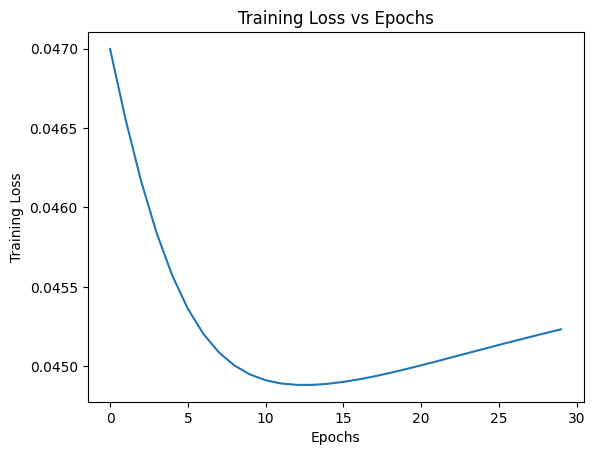

In [248]:
train_set_perturbed = input_perturbation(train_dataset, 1, 0.7 * eps)
mf_dp_data = MatrixFactorization(train_set_perturbed, maps_dict, num_of_latent_factors, relevance=4, i_avg=i_avg, u_avg=u_avg)
mf_dp_data.train(learning_rate, lambda_regularization, num_of_epochs)
mf_dp_data.evaluate(test_dataset)

 Epoch 1/30 started


100%|██████████| 80419/80419 [00:02<00:00, 28327.07it/s]


 Epoch 2/30 started


100%|██████████| 80419/80419 [00:01<00:00, 42787.55it/s]


 Epoch 3/30 started


100%|██████████| 80419/80419 [00:01<00:00, 44714.51it/s]


 Epoch 4/30 started


100%|██████████| 80419/80419 [00:01<00:00, 43594.43it/s]


 Epoch 5/30 started


100%|██████████| 80419/80419 [00:02<00:00, 26883.16it/s]


 Epoch 6/30 started


100%|██████████| 80419/80419 [00:03<00:00, 22808.51it/s]


 Epoch 7/30 started


100%|██████████| 80419/80419 [00:01<00:00, 45119.16it/s]


 Epoch 8/30 started


100%|██████████| 80419/80419 [00:01<00:00, 44137.94it/s]


 Epoch 9/30 started


100%|██████████| 80419/80419 [00:02<00:00, 31876.92it/s]


 Epoch 10/30 started


100%|██████████| 80419/80419 [00:05<00:00, 15289.24it/s]


 Epoch 11/30 started


100%|██████████| 80419/80419 [00:02<00:00, 35337.30it/s]


 Epoch 12/30 started


100%|██████████| 80419/80419 [00:04<00:00, 19173.07it/s]


 Epoch 13/30 started


100%|██████████| 80419/80419 [00:03<00:00, 26192.90it/s]


 Epoch 14/30 started


100%|██████████| 80419/80419 [00:03<00:00, 24454.34it/s]


 Epoch 15/30 started


100%|██████████| 80419/80419 [00:01<00:00, 45321.84it/s]


 Epoch 16/30 started


100%|██████████| 80419/80419 [00:01<00:00, 41542.59it/s]


 Epoch 17/30 started


100%|██████████| 80419/80419 [00:01<00:00, 44523.93it/s]


 Epoch 18/30 started


100%|██████████| 80419/80419 [00:01<00:00, 44601.96it/s]


 Epoch 19/30 started


100%|██████████| 80419/80419 [00:01<00:00, 44365.91it/s]


 Epoch 20/30 started


100%|██████████| 80419/80419 [00:02<00:00, 28976.89it/s]


 Epoch 21/30 started


100%|██████████| 80419/80419 [00:02<00:00, 34540.95it/s]


 Epoch 22/30 started


100%|██████████| 80419/80419 [00:01<00:00, 45616.74it/s]


 Epoch 23/30 started


100%|██████████| 80419/80419 [00:01<00:00, 44758.21it/s]


 Epoch 24/30 started


100%|██████████| 80419/80419 [00:01<00:00, 46074.85it/s]


 Epoch 25/30 started


100%|██████████| 80419/80419 [00:01<00:00, 43204.48it/s]


 Epoch 26/30 started


100%|██████████| 80419/80419 [00:01<00:00, 42693.02it/s]


 Epoch 27/30 started


100%|██████████| 80419/80419 [00:03<00:00, 25839.86it/s]


 Epoch 28/30 started


100%|██████████| 80419/80419 [00:01<00:00, 44970.58it/s]


 Epoch 29/30 started


100%|██████████| 80419/80419 [00:01<00:00, 44165.81it/s]


 Epoch 30/30 started


100%|██████████| 80419/80419 [00:01<00:00, 45507.29it/s]


TL: [38.62129720111559, 38.67653516056894, 38.56381173700862, 38.66580826499252, 38.79194880891551, 38.41660614644643, 38.5828726903345, 39.036728723701415, 38.5006742608195, 38.438998642077394, 38.49658697781682, 38.8954537016314, 38.49861331134405, 38.65754201965382, 38.50601790747633, 38.60262003546783, 38.62972354084728, 38.66925298450887, 38.63595441725779, 38.61353403591644, 38.73796924432584, 38.66342036111248, 38.59730176203941, 38.71096950920638, 38.85472787440291, 38.64275364278488, 38.70696690210543, 38.74408804278524, 39.07029600314887, 38.799637387807635]
Epochs: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
Precision@10: 0.020655737704917996
Recall@10: 0.010018215171984928


(0.020655737704917996, 0.010018215171984928)

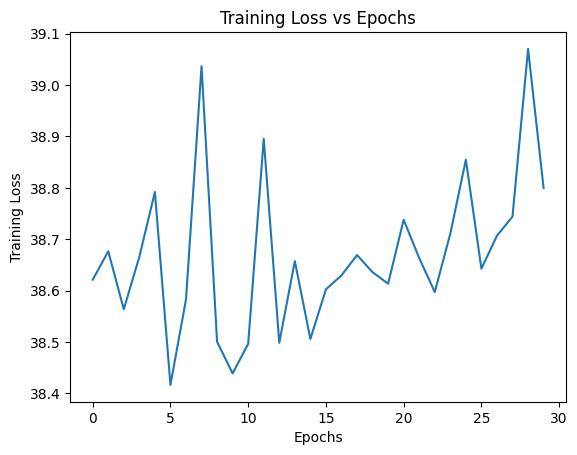

In [250]:
mf_dp_sgd = MatrixFactorization(train_dataset, maps_dict, num_of_latent_factors, relevance=4, i_avg=i_avg, u_avg=u_avg)
mf_dp_sgd.train_laplace_dp(learning_rate, lambda_regularization, num_of_epochs, 0.7 * eps)
mf_dp_sgd.evaluate(test_dataset)

eps 0.2
*** Epoch 1/30 ***


100%|██████████| 80419/80419 [00:01<00:00, 47780.47it/s]


*** Epoch 2/30 ***


100%|██████████| 80419/80419 [00:01<00:00, 48001.00it/s]


*** Epoch 3/30 ***


100%|██████████| 80419/80419 [00:01<00:00, 46955.04it/s]


*** Epoch 4/30 ***


100%|██████████| 80419/80419 [00:01<00:00, 48524.95it/s]


*** Epoch 5/30 ***


100%|██████████| 80419/80419 [00:02<00:00, 33168.23it/s]


*** Epoch 6/30 ***


100%|██████████| 80419/80419 [00:02<00:00, 34580.24it/s]


*** Epoch 7/30 ***


100%|██████████| 80419/80419 [00:01<00:00, 47183.09it/s]


*** Epoch 8/30 ***


100%|██████████| 80419/80419 [00:01<00:00, 47142.63it/s]


*** Epoch 9/30 ***


100%|██████████| 80419/80419 [00:01<00:00, 47672.76it/s]


*** Epoch 10/30 ***


100%|██████████| 80419/80419 [00:01<00:00, 47259.57it/s]


*** Epoch 11/30 ***


100%|██████████| 80419/80419 [00:01<00:00, 46872.42it/s]


*** Epoch 12/30 ***


100%|██████████| 80419/80419 [00:02<00:00, 28901.12it/s]


*** Epoch 13/30 ***


100%|██████████| 80419/80419 [00:02<00:00, 37471.11it/s]


*** Epoch 14/30 ***


100%|██████████| 80419/80419 [00:01<00:00, 46716.73it/s]


*** Epoch 15/30 ***


100%|██████████| 80419/80419 [00:01<00:00, 49113.92it/s]


*** Epoch 16/30 ***


100%|██████████| 80419/80419 [00:01<00:00, 44304.12it/s]


*** Epoch 17/30 ***


100%|██████████| 80419/80419 [00:01<00:00, 45456.84it/s]


*** Epoch 18/30 ***


100%|██████████| 80419/80419 [00:01<00:00, 47218.93it/s]


*** Epoch 19/30 ***


100%|██████████| 80419/80419 [00:02<00:00, 27211.44it/s]


*** Epoch 20/30 ***


100%|██████████| 80419/80419 [00:01<00:00, 42512.02it/s]


*** Epoch 21/30 ***


100%|██████████| 80419/80419 [00:01<00:00, 47034.19it/s]


*** Epoch 22/30 ***


100%|██████████| 80419/80419 [00:01<00:00, 47819.26it/s]


*** Epoch 23/30 ***


100%|██████████| 80419/80419 [00:01<00:00, 47582.49it/s]


*** Epoch 24/30 ***


100%|██████████| 80419/80419 [00:01<00:00, 47017.23it/s]


*** Epoch 25/30 ***


100%|██████████| 80419/80419 [00:01<00:00, 48075.35it/s]


*** Epoch 26/30 ***


100%|██████████| 80419/80419 [00:03<00:00, 26262.90it/s]


*** Epoch 27/30 ***


100%|██████████| 80419/80419 [00:01<00:00, 47219.74it/s]


*** Epoch 28/30 ***


100%|██████████| 80419/80419 [00:01<00:00, 44717.33it/s]


*** Epoch 29/30 ***


100%|██████████| 80419/80419 [00:01<00:00, 46295.16it/s]


*** Epoch 30/30 ***


100%|██████████| 80419/80419 [00:01<00:00, 46928.34it/s]


Precision@10: 0.014918032786885221
Recall@10: 0.0057365161686028275
 Epoch 1/30 started


  0%|          | 0/80419 [00:00<?, ?it/s]<ipython-input-238-7b83070faeca>:104: RuntimeWarning: overflow encountered in multiply
  self.q[self.dataset['itemId'][i]] = q_i + lr * (err * p_u)
<ipython-input-238-7b83070faeca>:100: RuntimeWarning: invalid value encountered in double_scalars
  self.b_u[self.dataset['userId'][i]] += lr * (err - beta * self.b_u[self.dataset['userId'][i]])
<ipython-input-238-7b83070faeca>:103: RuntimeWarning: invalid value encountered in add
  self.p[self.dataset['userId'][i]] = p_u + lr * (err * q_i)
<ipython-input-238-7b83070faeca>:103: RuntimeWarning: overflow encountered in multiply
  self.p[self.dataset['userId'][i]] = p_u + lr * (err * q_i)
100%|██████████| 80419/80419 [00:03<00:00, 26711.56it/s]


 Epoch 2/30 started


100%|██████████| 80419/80419 [00:01<00:00, 41614.57it/s]


 Epoch 3/30 started


100%|██████████| 80419/80419 [00:01<00:00, 44369.42it/s]


 Epoch 4/30 started


100%|██████████| 80419/80419 [00:01<00:00, 44238.04it/s]


 Epoch 5/30 started


100%|██████████| 80419/80419 [00:01<00:00, 44381.38it/s]


 Epoch 6/30 started


100%|██████████| 80419/80419 [00:01<00:00, 43149.26it/s]


 Epoch 7/30 started


100%|██████████| 80419/80419 [00:02<00:00, 33349.01it/s]


 Epoch 8/30 started


100%|██████████| 80419/80419 [00:02<00:00, 30801.59it/s]


 Epoch 9/30 started


100%|██████████| 80419/80419 [00:01<00:00, 43709.53it/s]


 Epoch 10/30 started


100%|██████████| 80419/80419 [00:01<00:00, 44046.76it/s]


 Epoch 11/30 started


100%|██████████| 80419/80419 [00:01<00:00, 42582.23it/s]


 Epoch 12/30 started


100%|██████████| 80419/80419 [00:01<00:00, 44927.20it/s]


 Epoch 13/30 started


100%|██████████| 80419/80419 [00:02<00:00, 38365.01it/s]


 Epoch 14/30 started


100%|██████████| 80419/80419 [00:03<00:00, 26389.64it/s]


 Epoch 15/30 started


100%|██████████| 80419/80419 [00:01<00:00, 44307.78it/s]


 Epoch 16/30 started


100%|██████████| 80419/80419 [00:01<00:00, 42642.40it/s]


 Epoch 17/30 started


100%|██████████| 80419/80419 [00:01<00:00, 42861.54it/s]


 Epoch 18/30 started


100%|██████████| 80419/80419 [00:01<00:00, 44137.55it/s]


 Epoch 19/30 started


100%|██████████| 80419/80419 [00:01<00:00, 44204.54it/s]


 Epoch 20/30 started


100%|██████████| 80419/80419 [00:02<00:00, 28008.54it/s]


 Epoch 21/30 started


100%|██████████| 80419/80419 [00:02<00:00, 36891.07it/s]


 Epoch 22/30 started


100%|██████████| 80419/80419 [00:01<00:00, 44096.50it/s]


 Epoch 23/30 started


100%|██████████| 80419/80419 [00:01<00:00, 43953.01it/s]


 Epoch 24/30 started


100%|██████████| 80419/80419 [00:01<00:00, 44273.37it/s]


 Epoch 25/30 started


100%|██████████| 80419/80419 [00:01<00:00, 43958.75it/s]


 Epoch 26/30 started


100%|██████████| 80419/80419 [00:02<00:00, 36785.82it/s]


 Epoch 27/30 started


100%|██████████| 80419/80419 [00:02<00:00, 29137.00it/s]


 Epoch 28/30 started


100%|██████████| 80419/80419 [00:01<00:00, 45000.46it/s]


 Epoch 29/30 started


100%|██████████| 80419/80419 [00:01<00:00, 44652.00it/s]


 Epoch 30/30 started


100%|██████████| 80419/80419 [00:01<00:00, 42610.19it/s]


TL: [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]
Epochs: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
Precision@10: 0.003442622950819673
Recall@10: 0.0008590498525753539
eps 1
*** Epoch 1/30 ***


100%|██████████| 80419/80419 [00:03<00:00, 26259.51it/s]


*** Epoch 2/30 ***


100%|██████████| 80419/80419 [00:01<00:00, 46542.66it/s]


*** Epoch 3/30 ***


100%|██████████| 80419/80419 [00:01<00:00, 46614.60it/s]


*** Epoch 4/30 ***


100%|██████████| 80419/80419 [00:01<00:00, 46902.92it/s]


*** Epoch 5/30 ***


100%|██████████| 80419/80419 [00:01<00:00, 47415.26it/s]


*** Epoch 6/30 ***


100%|██████████| 80419/80419 [00:01<00:00, 45143.78it/s]


*** Epoch 7/30 ***


100%|██████████| 80419/80419 [00:02<00:00, 37873.66it/s]


*** Epoch 8/30 ***


100%|██████████| 80419/80419 [00:02<00:00, 29169.04it/s]


*** Epoch 9/30 ***


100%|██████████| 80419/80419 [00:01<00:00, 47792.88it/s]


*** Epoch 10/30 ***


100%|██████████| 80419/80419 [00:01<00:00, 46614.61it/s]


*** Epoch 11/30 ***


100%|██████████| 80419/80419 [00:01<00:00, 47337.89it/s]


*** Epoch 12/30 ***


100%|██████████| 80419/80419 [00:01<00:00, 47916.47it/s]


*** Epoch 13/30 ***


100%|██████████| 80419/80419 [00:01<00:00, 47004.68it/s]


*** Epoch 14/30 ***


100%|██████████| 80419/80419 [00:02<00:00, 35061.76it/s]


*** Epoch 15/30 ***


100%|██████████| 80419/80419 [00:02<00:00, 31262.66it/s]


*** Epoch 16/30 ***


100%|██████████| 80419/80419 [00:01<00:00, 46908.74it/s]


*** Epoch 17/30 ***


100%|██████████| 80419/80419 [00:01<00:00, 47645.28it/s]


*** Epoch 18/30 ***


100%|██████████| 80419/80419 [00:01<00:00, 45003.59it/s]


*** Epoch 19/30 ***


100%|██████████| 80419/80419 [00:01<00:00, 46589.98it/s]


*** Epoch 20/30 ***


100%|██████████| 80419/80419 [00:01<00:00, 46217.02it/s]


*** Epoch 21/30 ***


100%|██████████| 80419/80419 [00:02<00:00, 31929.84it/s]


*** Epoch 22/30 ***


100%|██████████| 80419/80419 [00:02<00:00, 34074.27it/s]


*** Epoch 23/30 ***


100%|██████████| 80419/80419 [00:01<00:00, 47293.15it/s]


*** Epoch 24/30 ***


100%|██████████| 80419/80419 [00:01<00:00, 47009.68it/s]


*** Epoch 25/30 ***


100%|██████████| 80419/80419 [00:01<00:00, 45571.36it/s]


*** Epoch 26/30 ***


100%|██████████| 80419/80419 [00:01<00:00, 45012.95it/s]


*** Epoch 27/30 ***


100%|██████████| 80419/80419 [00:01<00:00, 47765.08it/s]


*** Epoch 28/30 ***


100%|██████████| 80419/80419 [00:02<00:00, 27202.25it/s]


*** Epoch 29/30 ***


100%|██████████| 80419/80419 [00:02<00:00, 39212.82it/s]


*** Epoch 30/30 ***


100%|██████████| 80419/80419 [00:01<00:00, 47063.34it/s]


Precision@10: 0.0163934426229508
Recall@10: 0.005225884853949886
 Epoch 1/30 started


100%|██████████| 80419/80419 [00:01<00:00, 43884.74it/s]


 Epoch 2/30 started


  0%|          | 0/80419 [00:00<?, ?it/s]<ipython-input-238-7b83070faeca>:103: RuntimeWarning: overflow encountered in multiply
  self.p[self.dataset['userId'][i]] = p_u + lr * (err * q_i)
<ipython-input-238-7b83070faeca>:104: RuntimeWarning: overflow encountered in multiply
  self.q[self.dataset['itemId'][i]] = q_i + lr * (err * p_u)
 63%|██████▎   | 50592/80419 [00:01<00:00, 43453.92it/s]<ipython-input-238-7b83070faeca>:104: RuntimeWarning: invalid value encountered in add
  self.q[self.dataset['itemId'][i]] = q_i + lr * (err * p_u)
 92%|█████████▏| 73709/80419 [00:01<00:00, 45264.90it/s]<ipython-input-238-7b83070faeca>:103: RuntimeWarning: invalid value encountered in add
  self.p[self.dataset['userId'][i]] = p_u + lr * (err * q_i)
100%|██████████| 80419/80419 [00:01<00:00, 44775.57it/s]


 Epoch 3/30 started


100%|██████████| 80419/80419 [00:02<00:00, 29922.74it/s]


 Epoch 4/30 started


100%|██████████| 80419/80419 [00:02<00:00, 33661.95it/s]


 Epoch 5/30 started


100%|██████████| 80419/80419 [00:01<00:00, 44914.86it/s]


 Epoch 6/30 started


100%|██████████| 80419/80419 [00:01<00:00, 43537.75it/s]


 Epoch 7/30 started


100%|██████████| 80419/80419 [00:01<00:00, 43411.45it/s]


 Epoch 8/30 started


100%|██████████| 80419/80419 [00:01<00:00, 44239.75it/s]


 Epoch 9/30 started


100%|██████████| 80419/80419 [00:02<00:00, 39315.04it/s]


 Epoch 10/30 started


100%|██████████| 80419/80419 [00:03<00:00, 25806.70it/s]


 Epoch 11/30 started


100%|██████████| 80419/80419 [00:01<00:00, 43838.59it/s]


 Epoch 12/30 started


100%|██████████| 80419/80419 [00:01<00:00, 44092.82it/s]


 Epoch 13/30 started


100%|██████████| 80419/80419 [00:01<00:00, 43954.56it/s]


 Epoch 14/30 started


100%|██████████| 80419/80419 [00:01<00:00, 45612.20it/s]


 Epoch 15/30 started


100%|██████████| 80419/80419 [00:01<00:00, 43856.52it/s]


 Epoch 16/30 started


100%|██████████| 80419/80419 [00:02<00:00, 28521.10it/s]


 Epoch 17/30 started


100%|██████████| 80419/80419 [00:02<00:00, 35497.93it/s]


 Epoch 18/30 started


100%|██████████| 80419/80419 [00:01<00:00, 43608.99it/s]


 Epoch 19/30 started


100%|██████████| 80419/80419 [00:01<00:00, 44421.13it/s]


 Epoch 20/30 started


100%|██████████| 80419/80419 [00:01<00:00, 43087.42it/s]


 Epoch 21/30 started


100%|██████████| 80419/80419 [00:01<00:00, 43784.43it/s]


 Epoch 22/30 started


100%|██████████| 80419/80419 [00:02<00:00, 37206.94it/s]


 Epoch 23/30 started


100%|██████████| 80419/80419 [00:02<00:00, 27177.98it/s]


 Epoch 24/30 started


100%|██████████| 80419/80419 [00:01<00:00, 42832.49it/s]


 Epoch 25/30 started


100%|██████████| 80419/80419 [00:01<00:00, 43244.91it/s]


 Epoch 26/30 started


100%|██████████| 80419/80419 [00:01<00:00, 43357.77it/s]


 Epoch 27/30 started


100%|██████████| 80419/80419 [00:01<00:00, 43779.06it/s]


 Epoch 28/30 started


100%|██████████| 80419/80419 [00:01<00:00, 44721.42it/s]


 Epoch 29/30 started


100%|██████████| 80419/80419 [00:03<00:00, 25373.78it/s]


 Epoch 30/30 started


100%|██████████| 80419/80419 [00:02<00:00, 37660.38it/s]


TL: [227.91096299278476, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]
Epochs: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
Precision@10: 0.003442622950819673
Recall@10: 0.0008590498525753539
eps 5
*** Epoch 1/30 ***


100%|██████████| 80419/80419 [00:01<00:00, 45022.33it/s]


*** Epoch 2/30 ***


100%|██████████| 80419/80419 [00:01<00:00, 45915.73it/s]


*** Epoch 3/30 ***


100%|██████████| 80419/80419 [00:03<00:00, 25217.34it/s]


*** Epoch 4/30 ***


100%|██████████| 80419/80419 [00:01<00:00, 41220.21it/s]


*** Epoch 5/30 ***


100%|██████████| 80419/80419 [00:01<00:00, 45361.71it/s]


*** Epoch 6/30 ***


100%|██████████| 80419/80419 [00:01<00:00, 44626.77it/s]


*** Epoch 7/30 ***


100%|██████████| 80419/80419 [00:01<00:00, 44961.47it/s]


*** Epoch 8/30 ***


100%|██████████| 80419/80419 [00:01<00:00, 43772.79it/s]


*** Epoch 9/30 ***


100%|██████████| 80419/80419 [00:02<00:00, 35489.74it/s]


*** Epoch 10/30 ***


100%|██████████| 80419/80419 [00:02<00:00, 28673.77it/s]


*** Epoch 11/30 ***


100%|██████████| 80419/80419 [00:01<00:00, 44853.32it/s]


*** Epoch 12/30 ***


100%|██████████| 80419/80419 [00:01<00:00, 45650.23it/s]


*** Epoch 13/30 ***


100%|██████████| 80419/80419 [00:01<00:00, 45768.41it/s]


*** Epoch 14/30 ***


100%|██████████| 80419/80419 [00:01<00:00, 43071.75it/s]


*** Epoch 15/30 ***


100%|██████████| 80419/80419 [00:01<00:00, 45266.15it/s]


*** Epoch 16/30 ***


100%|██████████| 80419/80419 [00:02<00:00, 28013.89it/s]


*** Epoch 17/30 ***


100%|██████████| 80419/80419 [00:02<00:00, 37161.54it/s]


*** Epoch 18/30 ***


100%|██████████| 80419/80419 [00:01<00:00, 44227.16it/s]


*** Epoch 19/30 ***


100%|██████████| 80419/80419 [00:01<00:00, 45274.60it/s]


*** Epoch 20/30 ***


100%|██████████| 80419/80419 [00:01<00:00, 44354.86it/s]


*** Epoch 21/30 ***


100%|██████████| 80419/80419 [00:01<00:00, 46153.37it/s]


*** Epoch 22/30 ***


100%|██████████| 80419/80419 [00:01<00:00, 42422.10it/s]


*** Epoch 23/30 ***


100%|██████████| 80419/80419 [00:03<00:00, 26117.27it/s]


*** Epoch 24/30 ***


100%|██████████| 80419/80419 [00:01<00:00, 46411.68it/s]


*** Epoch 25/30 ***


100%|██████████| 80419/80419 [00:01<00:00, 46329.75it/s]


*** Epoch 26/30 ***


100%|██████████| 80419/80419 [00:01<00:00, 46972.70it/s]


*** Epoch 27/30 ***


100%|██████████| 80419/80419 [00:01<00:00, 44764.62it/s]


*** Epoch 28/30 ***


100%|██████████| 80419/80419 [00:01<00:00, 46385.15it/s]


*** Epoch 29/30 ***


100%|██████████| 80419/80419 [00:02<00:00, 34607.95it/s]


*** Epoch 30/30 ***


100%|██████████| 80419/80419 [00:02<00:00, 29391.23it/s]


Precision@10: 0.021147540983606522
Recall@10: 0.008939836340359074
 Epoch 1/30 started


100%|██████████| 80419/80419 [00:01<00:00, 44683.77it/s]


 Epoch 2/30 started


100%|██████████| 80419/80419 [00:01<00:00, 42145.81it/s]


 Epoch 3/30 started


100%|██████████| 80419/80419 [00:01<00:00, 42681.80it/s]


 Epoch 4/30 started


100%|██████████| 80419/80419 [00:02<00:00, 28095.79it/s]


 Epoch 5/30 started


100%|██████████| 80419/80419 [00:02<00:00, 34285.66it/s]


 Epoch 6/30 started


100%|██████████| 80419/80419 [00:01<00:00, 43566.29it/s]


 Epoch 7/30 started


100%|██████████| 80419/80419 [00:01<00:00, 42988.77it/s]


 Epoch 8/30 started


100%|██████████| 80419/80419 [00:01<00:00, 42763.02it/s]


 Epoch 9/30 started


100%|██████████| 80419/80419 [00:01<00:00, 44417.63it/s]


 Epoch 10/30 started


100%|██████████| 80419/80419 [00:02<00:00, 34527.20it/s]


 Epoch 11/30 started


100%|██████████| 80419/80419 [00:02<00:00, 28227.32it/s]


 Epoch 12/30 started


100%|██████████| 80419/80419 [00:01<00:00, 44123.31it/s]


 Epoch 13/30 started


100%|██████████| 80419/80419 [00:01<00:00, 44114.33it/s]


 Epoch 14/30 started


100%|██████████| 80419/80419 [00:01<00:00, 43026.20it/s]


 Epoch 15/30 started


100%|██████████| 80419/80419 [00:01<00:00, 42969.47it/s]


 Epoch 16/30 started


100%|██████████| 80419/80419 [00:01<00:00, 43094.73it/s]


 Epoch 17/30 started


100%|██████████| 80419/80419 [00:03<00:00, 24993.45it/s]


 Epoch 18/30 started


100%|██████████| 80419/80419 [00:02<00:00, 39984.23it/s]


 Epoch 19/30 started


100%|██████████| 80419/80419 [00:01<00:00, 42916.41it/s]


 Epoch 20/30 started


100%|██████████| 80419/80419 [00:01<00:00, 41673.93it/s]


 Epoch 21/30 started


100%|██████████| 80419/80419 [00:01<00:00, 43717.38it/s]


 Epoch 22/30 started


100%|██████████| 80419/80419 [00:01<00:00, 43488.50it/s]


 Epoch 23/30 started


100%|██████████| 80419/80419 [00:02<00:00, 29531.03it/s]


 Epoch 24/30 started


100%|██████████| 80419/80419 [00:02<00:00, 33534.33it/s]


 Epoch 25/30 started


100%|██████████| 80419/80419 [00:01<00:00, 43857.93it/s]


 Epoch 26/30 started


100%|██████████| 80419/80419 [00:01<00:00, 44294.70it/s]


 Epoch 27/30 started


100%|██████████| 80419/80419 [00:03<00:00, 26546.17it/s]


 Epoch 28/30 started


100%|██████████| 80419/80419 [00:02<00:00, 39295.11it/s]


 Epoch 29/30 started


100%|██████████| 80419/80419 [00:03<00:00, 25419.55it/s]


 Epoch 30/30 started


100%|██████████| 80419/80419 [00:01<00:00, 41006.51it/s]


TL: [38.499749864603224, 38.522736535151985, 38.465418119606895, 38.5130330626537, 38.559922390814, 38.67165365244685, 38.62755463601472, 38.627575909699154, 38.6366872852069, 38.89158631484105, 38.68438401794768, 38.55420643236917, 38.67467443686851, 38.749443187278445, 38.535117266806694, 38.50350286559254, 38.70383000298179, 38.616234521116205, 38.57987290295162, 38.521667381309626, 38.813792630157536, 38.53667214263788, 38.845550514515594, 38.844040053149484, 38.66141615277506, 38.57307966584653, 38.669438470144875, 38.70018432346349, 38.75513205609446, 38.85402073534546]
Epochs: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
Precision@10: 0.02508196721311471
Recall@10: 0.010593550672482927


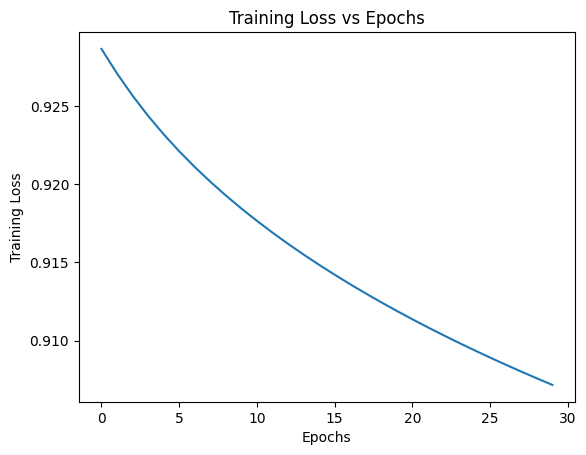

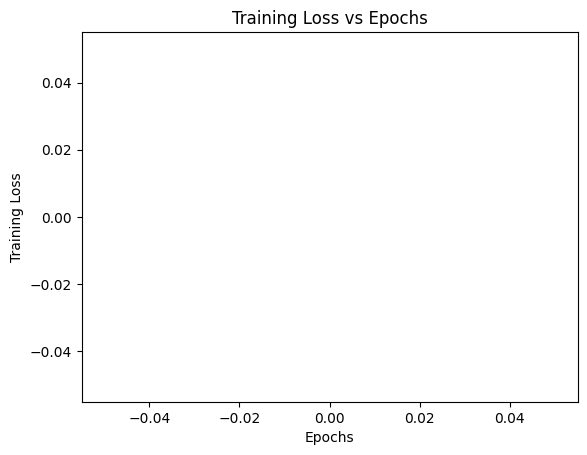

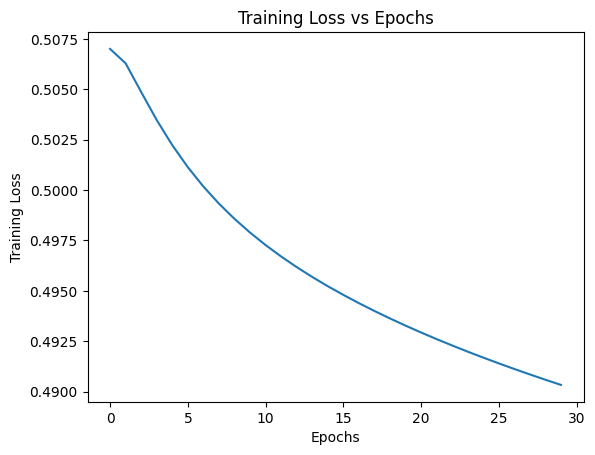

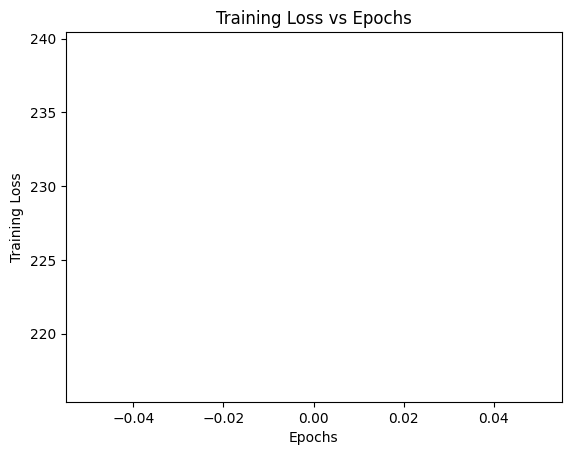

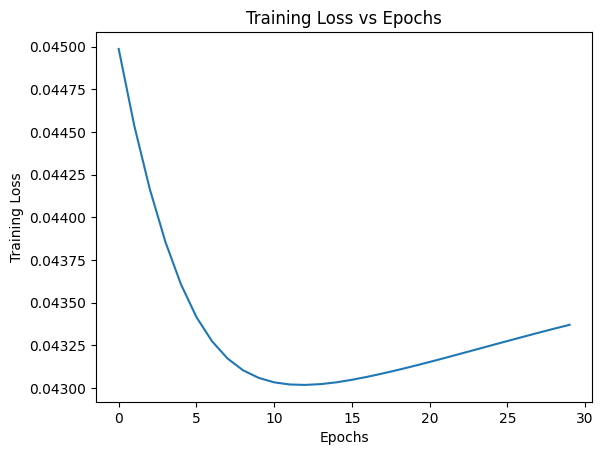

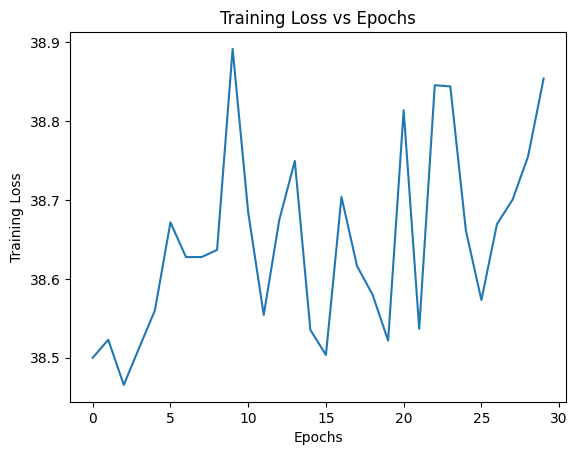

In [259]:
eps_values = [0.2, 1, 5]
results = {}
for eps in eps_values:
    print(f"eps {eps}")
    eps_global_avg = 0.02 * eps
    eps_item_avg = 0.14 * eps
    eps_user_avg = 0.14 * eps
    b_m = 5
    b_u = 5
    clamping = 1
    preproc_train_set, i_avg, u_avg = privatize_global_effects(train_dataset, b_m, b_u, eps_global_avg, eps_item_avg,
                                                               eps_user_avg, clamping)
    train_set_perturbed = input_perturbation(train_dataset, 1, 0.7 * eps)
    mf_dp_data = MatrixFactorization(train_set_perturbed, maps_dict, num_of_latent_factors, relevance=4, i_avg=i_avg, u_avg=u_avg)
    mf_dp_data.train(learning_rate, lambda_regularization, num_of_epochs)
    p_d, r_d = mf_dp_data.evaluate(test_dataset)

    mf_dp_sgd = MatrixFactorization(train_dataset, maps_dict, num_of_latent_factors, relevance=4, i_avg=i_avg, u_avg=u_avg)
    mf_dp_sgd.train_laplace_dp(learning_rate, lambda_regularization, num_of_epochs, 0.7 * eps)
    p_m, r_m = mf_dp_sgd.evaluate(test_dataset)

    results.update({eps: (p_d, r_d, p_m, r_m)})

In [260]:
print(results)

{0.2: (0.014918032786885221, 0.0057365161686028275, 0.003442622950819673, 0.0008590498525753539), 1: (0.0163934426229508, 0.005225884853949886, 0.003442622950819673, 0.0008590498525753539), 5: (0.021147540983606522, 0.008939836340359074, 0.02508196721311471, 0.010593550672482927)}
